<a href="https://colab.research.google.com/github/cstrachan342/Object-Detection-Models-Pytorch-Lightning/blob/main/examples/object_detection_pipeline_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Training Pipeline Example**

There are many amazing guides on how to utilize Pytorch Lightning to its full capacities. This is just a very brief overview with some example code to show how it can be used in addition to the models in this repositiory. If you want to learn more about Pytorch Lightning I recommend watching the youtube series made by Aladdin Persson. The link to the first video is below:

https://www.youtube.com/watch?v=XbIN9LaQycQ&list=PLhhyoLH6IjfyL740PTuXef4TstxAK6nGP&ab_channel=AladdinPersson

To use my repository run the code below:

In [1]:
!git clone https://github.com/cstrachan342/Object-Detection-Models-Pytorch-Lightning

Cloning into 'Object-Detection-Models-Pytorch-Lightning'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 5), reused 15 (delta 2), pack-reused 0
Receiving objects: 100% (23/23), 12.95 KiB | 12.95 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
%cd /content/Object-Detection-Models-Pytorch-Lightning

/content/Object-Detection-Models-Pytorch-Lightning


In [3]:
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.3 MB/s eta 0:00:00


In [4]:
from models.faster_rcnn_pytorch_lightning import CustomFasterRCNN

The dataset I am using for this example belongs to UNICEF and presents 3 different types of houses to detect via drone footage. It is hosted on Kaggle and found if you follow this link - https://www.kaggle.com/datasets/rajsahu2004/arm-unicef-disaster-vulnerability-challenge-data. Some of the data is already saved in my google drive so I will be calling it from there.

In [5]:
import pytorch_lightning as pl
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import tifffile
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import warnings

In [6]:
BATCH_SIZE = 8
EPOCHS = 5

To use a Pytorch Lightning Model you need a DataModule and more than likely a custom Dataset. Below are examples of how they are constructed. The Dataset follow the basic structure of a Pytorch Dataset containg the essential methods of `__len__()` and `__getitem__()` with additional helper functions to efficiently load images and bounding boxes where necessary. To use FasterRCNN bounding boxes need to be in the `pascal_voc` format while DETR need to be in `COCO` format.

In [7]:
class FasterRCNNDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths: str, transform=None, annotation_df: pd.DataFrame = None, dataset:str = None):
        super().__init__()

        self.image_paths = image_paths
        self.annotation_df = annotation_df
        self.transform = transform
        self.dataset = dataset
        self.base_transform = A.Compose([ToTensorV2()])

    def __len__(self):
        return len(self.image_paths)

    def check_boxes(self, image_id):
        boxes = np.array(self.annotation_df[self.annotation_df['image_id']==str(image_id)].bbox.values.tolist())
        if len(boxes[0]) == 0:
            aug = False
        else:
            aug = True
        return aug

    def get_boxes(self, image_id):
        boxes = np.array(self.annotation_df[self.annotation_df['image_id']==str(image_id)].bbox.values.tolist())

        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        return boxes

    def __getitem__(self, index):
        image_id = self.image_paths[index]

        image = tifffile.imread(image_id).astype(np.float32) / 255.0
        image_id = image_id.split('/')[-1].replace('.tif', '').strip()

        if self.dataset == 'test':
            return self.base_transform(image=image)['image'], image_id

        aug = self.check_boxes(image_id)

        image_id_uniq = self.annotation_df[self.annotation_df['image_id']==str(image_id)].id_uniq.values.tolist()[0]
        class_labels = self.annotation_df[self.annotation_df['image_id']==str(image_id)].category_id.values.tolist()

        if (aug) & (self.transform is not None):
            boxes = self.get_boxes(image_id)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            transformed = self.transform(image = image, bboxes = boxes, class_labels = class_labels)
            image = transformed['image']

            if len(transformed['bboxes']) > 0:
                boxes = torch.stack(tuple(map(torch.tensor, zip(*transformed['bboxes'])))).permute(1, 0)

        elif (aug) & (self.transform is None):
            boxes = self.get_boxes(image_id)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            image = self.base_transform(image=image)['image']

        elif aug==False:
            image = self.base_transform(image=image)['image']
            area = []
            boxes = torch.zeros((0, 4), dtype=torch.int64)

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            'image_id': torch.tensor([image_id_uniq]),
            'labels': torch.as_tensor(class_labels, dtype=torch.int64),
            'iscrowd': torch.zeros((0), dtype=torch.int64)
        }

        return image, target


Data Module needs to contain `setup()`, `prepare_data()` which are used to download data, then split up and define datasets. Then you need `train_dataloader()` and if you have a validation set then `val_dataloader()`. Whether or not you want to train with a validation and test set can be configued in the LightningModule and LightningDataModule.

In [8]:
class FasterRCNNDataModule(pl.LightningDataModule):
      def __init__(self, dir_prefix=None, batch_size=None, num_workers=None, transform=None, split=0, random_state=None):
          super().__init__()
          self.batch_size = batch_size
          self.num_workers = num_workers
          self.dir_prefix = dir_prefix
          self.transform = transform
          self.split = split
          self.random_state = random_state

      def create_datasets(self, dir_prefix=None, split=0, random_state=None, data_df=None, test=False):
          if test == True:
              return np.array([str(dir_prefix) + entry + '.tif' for entry in pd.read_csv('/content/drive/MyDrive/UNICEF_disaster/test.csv')['image_id'].tolist()])

          data = self.data_df['image_id'].drop_duplicates()
          train, val = train_test_split(data, test_size=split, random_state=random_state)

          train = np.array([str(dir_prefix) + entry + '.tif' for entry in train])
          val = np.array([str(dir_prefix) + entry + '.tif' for entry in val])

          return train, val

      def collate_fn(self, batch):
          return tuple(zip(*batch))

      def convert_to_coco_float(self, bbox):
          if pd.isnull(bbox)==True:
              return np.nan
          bboxes = np.array(bbox.replace('[', '').replace(']', '').split(','))
          x, y, w, h = np.float32(bboxes[0]), np.float32(bboxes[1]), np.float32(bboxes[2]), np.float32(bboxes[3])
          return [x, y, w, h]

      def prepare_data(self):
          self.data_df = pd.read_csv('/content/drive/MyDrive/UNICEF_disaster/data.csv')
          self.data_df['id_uniq'] = self.data_df.groupby(['image_id']).ngroup()
          self.data_df['bbox'] = self.data_df['bbox'].apply(self.convert_to_coco_float)
          self.data_df['bbox'] = self.data_df['bbox'].fillna('[]')
          self.data_df['bbox'] = self.data_df['bbox'].apply(lambda x: eval(x) if not isinstance(x, list) else x)
          self.data_df['category_id'] = self.data_df['category_id'].fillna('[]')
          self.data_df['category_id'] = self.data_df['category_id'].apply(lambda x: eval(x) if not isinstance(x, float) else x)
          index_drop = self.data_df[self.data_df['bbox'].apply(lambda x: 0 in x[2:] if isinstance(x, list) else False)].index
          self.data_df = self.data_df.drop(index=index_drop)

      def setup(self, stage):
          test = self.create_datasets(dir_prefix=self.dir_prefix,
                                      split=self.split,
                                      random_state=self.random_state,
                                      data_df=self.data_df,
                                      test=True)

          train, val = self.create_datasets(dir_prefix=self.dir_prefix,
                                            split=self.split,
                                            random_state=self.random_state,
                                            data_df=self.data_df,
                                            test=False)

          self.train_data = FasterRCNNDataset(train, transform=self.transform, annotation_df=self.data_df, dataset='train')
          self.val_data = FasterRCNNDataset(val, transform=None, annotation_df=self.data_df, dataset='val')
          self.test_data = FasterRCNNDataset(test, transform=None, annotation_df=self.data_df, dataset='test')

      def train_dataloader(self):
        return DataLoader(dataset=self.train_data,
                          collate_fn=self.collate_fn,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True)

      def val_dataloader(self):
        return DataLoader(dataset=self.val_data,
                          collate_fn=self.collate_fn,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False)

      def test_dataloader(self):
        return DataLoader(dataset=self.test_data,
                          collate_fn=self.collate_fn,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False)


In [9]:
transforms = A.Compose([A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.1),
                        A.RandomBrightnessContrast(p=0.25),
                        ToTensorV2()], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.1, label_fields=['class_labels'],)
)

In [10]:
dm = FasterRCNNDataModule(dir_prefix = '/content/Images/',
                          batch_size = BATCH_SIZE,
                          num_workers = 7,
                          transform=transforms,
                          split = 0.15,
                          random_state = 17)

Initialize the model then use Pytorch Lightning `Trainer()` to begin the training process.

In [22]:
%cd /content/

/content


In [11]:
warnings.filterwarnings("ignore")

In [12]:
model = CustomFasterRCNN(lr=1e-5, weight_decay=5e-4, num_classes=4, batch_size=BATCH_SIZE, score_threshold=0.5, nms_iou_threshold=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.4MB/s]


In [13]:
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=1, log_every_n_steps=100, check_val_every_n_epoch=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.3 M    Trainable params
0         Non-trainable params
41.3 M    Total params
165.243   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Train Loss Classifier: 0.08220382779836655, Train Loss Objectness: 0.08318809419870377, Train Loss Box Reg: 0.10833508521318436, Train Loss Rpn Box Reg: 0.008745997212827206, Validation Loss Classifier: 0.08329446613788605, Validation Loss Objectness: 0.020599428564310074  Validation Loss Box Reg: 0.12637144327163696, Validation Loss Rpn Box Reg: N/A,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Train Loss Classifier: 0.07865321636199951, Train Loss Objectness: 0.01474637258797884, Train Loss Box Reg: 0.12500570714473724, Train Loss Rpn Box Reg: 0.005755909718573093, Validation Loss Classifier: 0.08564957231283188, Validation Loss Objectness: 0.015953436493873596  Validation Loss Box Reg: 0.13129077851772308, Validation Loss Rpn Box Reg: N/A,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Train Loss Classifier: 0.08121222257614136, Train Loss Objectness: 0.011785050854086876, Train Loss Box Reg: 0.12590934336185455, Train Loss Rpn Box Reg: 0.004826709162443876, Validation Loss Classifier: 0.09340105950832367, Validation Loss Objectness: 0.014207178726792336  Validation Loss Box Reg: 0.12861968576908112, Validation Loss Rpn Box Reg: N/A,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Train Loss Classifier: 0.08416995406150818, Train Loss Objectness: 0.00993526540696621, Train Loss Box Reg: 0.12633034586906433, Train Loss Rpn Box Reg: 0.004512328188866377, Validation Loss Classifier: 0.0902777761220932, Validation Loss Objectness: 0.01254226267337799  Validation Loss Box Reg: 0.12940727174282074, Validation Loss Rpn Box Reg: N/A,


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Train Loss Classifier: 0.08427948504686356, Train Loss Objectness: 0.008972197771072388, Train Loss Box Reg: 0.12564729154109955, Train Loss Rpn Box Reg: 0.004430417437106371, Validation Loss Classifier: 0.09060458838939667, Validation Loss Objectness: 0.011297421529889107  Validation Loss Box Reg: 0.1361551284790039, Validation Loss Rpn Box Reg: N/A,


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Within the class there is a predict function that can be called to show a random selection of image predictions.

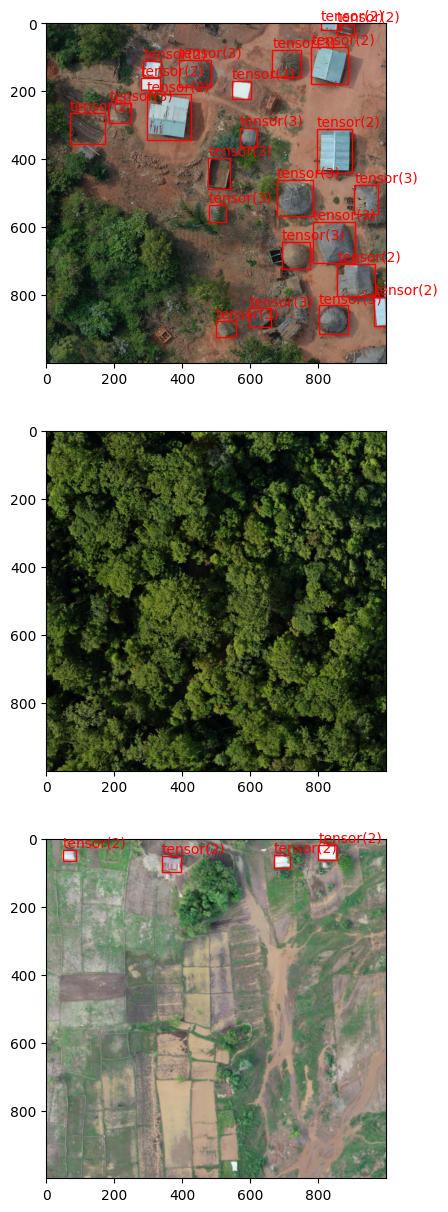

In [27]:
model.predict_rand(images=None, dm=dm)

If you want to replace or add any new methods you can easily subclass then write new code dependant on your needs. Or enter the docs and copy the whole class and adapt that way, whatever your preference is.